In [17]:
!pip install easyocr transformers torch torchvision torchaudio scikit-image scikit-learn

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import zipfile

zip_path = "/content/drive/MyDrive/Colab Notebooks (1)/MNA/Proyecto Integrador/20260121 imagenes Cashcollection1.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/Colab Notebooks/MNA/Proyecto Integrador/dataset_bimbonet')


In [20]:
import os

base_path = "/content/drive/MyDrive/Colab Notebooks/MNA/Proyecto Integrador/dataset_bimbonet/20260121 imagenes Cashcollection"

files = os.listdir(base_path)
len(files), files[:10]

(850,
 ['1.jpeg',
  '10.jpeg',
  '100.jpg',
  '101.png',
  '102.png',
  '103.png',
  '104.png',
  '105.png',
  '106.png',
  '107.png'])

In [21]:
IMAGE_DIR = "/content/drive/MyDrive/Colab Notebooks/MNA/Proyecto Integrador/dataset_bimbonet/20260121 imagenes Cashcollection"

In [22]:
import os

image_paths = [os.path.join(IMAGE_DIR,f)
              for f in os.listdir (IMAGE_DIR)
              if f.lower().endswith((".jpg", ".jpeg", ".png", ".jfif"))]

len (image_paths), image_paths[:5]

(850,
 ['/content/drive/MyDrive/Colab Notebooks/MNA/Proyecto Integrador/dataset_bimbonet/20260121 imagenes Cashcollection/1.jpeg',
  '/content/drive/MyDrive/Colab Notebooks/MNA/Proyecto Integrador/dataset_bimbonet/20260121 imagenes Cashcollection/10.jpeg',
  '/content/drive/MyDrive/Colab Notebooks/MNA/Proyecto Integrador/dataset_bimbonet/20260121 imagenes Cashcollection/100.jpg',
  '/content/drive/MyDrive/Colab Notebooks/MNA/Proyecto Integrador/dataset_bimbonet/20260121 imagenes Cashcollection/101.png',
  '/content/drive/MyDrive/Colab Notebooks/MNA/Proyecto Integrador/dataset_bimbonet/20260121 imagenes Cashcollection/102.png'])

In [25]:
import cv2
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import easyocr
import torch
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
import os


base_extract_path = "/content/drive/MyDrive/Colab Notebooks/MNA/Proyecto Integrador/dataset_bimbonet/20260121 imagenes Cashcollection"
LIMIT = 50

# Búsqueda recursiva "a prueba de balas"
image_paths = []
for root, dirs, files in os.walk(base_extract_path):
    for file in files:
        if file.lower().endswith((".png", ".jpg", ".jpeg", ".jfif")):
            image_paths.append(os.path.join(root, file))

print(f"Total de imágenes listas para procesar: {len(image_paths)}")

# Validación extra
if len(image_paths) == 0:
    print("⚠️ ADVERTENCIA: No se encontraron imágenes. Verifica que el ZIP contenía los archivos correctos.")

Total de imágenes listas para procesar: 850


# **EDA e Histogramas**

--- INICIANDO EDA ---


,height,width,aspect_ratio,brightness,blur
count,50.000000,50.000000,50.000000,50.000000,50.000000
mean,1520.220000,867.680000,1.799931,143.659854,334.856513
std,137.693877,163.237331,0.317407,19.540031,301.720416
min,1152.000000,509.000000,1.328904,71.522201,11.713072
25%,1477.500000,724.500000,1.777778,132.895634,119.302053
50%,1599.000000,899.000000,1.777778,143.229140,225.014191
75%,1600.000000,900.000000,1.778643,155.219638,470.502446
max,1600.000000,1204.000000,3.071017,180.761286,1514.440442


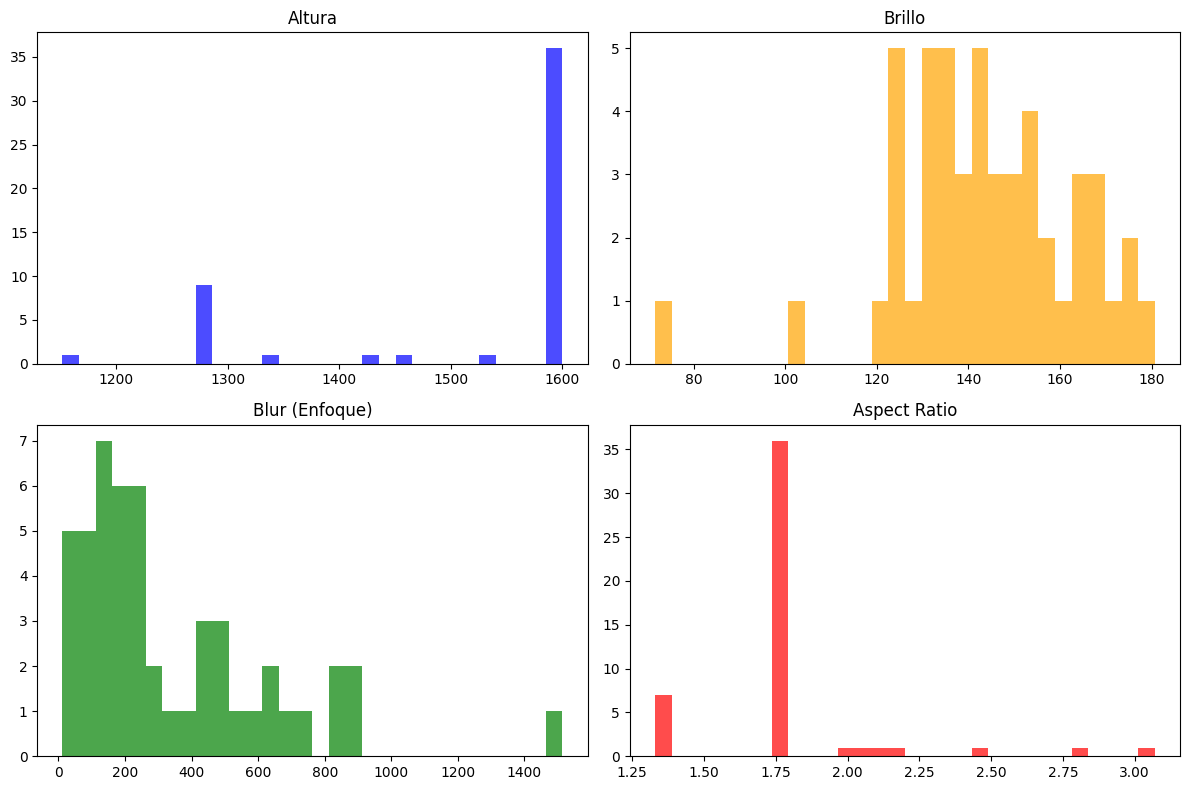

In [26]:
def analyze_image(path):
    img = cv2.imread(path)
    if img is None: return {"path": path, "valid": False}
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape
    return {
        "path": path, "valid": True, "height": h, "width": w,
        "aspect_ratio": h / w, "brightness": np.mean(gray),
        "blur": cv2.Laplacian(gray, cv2.CV_64F).var()
    }

print("--- INICIANDO EDA ---")
results = [analyze_image(path) for path in tqdm(image_paths[:LIMIT], desc="Analizando")]
df_valid = pd.DataFrame(results)[lambda x: x["valid"] == True]

# Mostrar métricas
display(df_valid.describe())

# Generar Histogramas en línea
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes[0, 0].hist(df_valid["height"], bins=30, color='blue', alpha=0.7); axes[0, 0].set_title("Altura")
axes[0, 1].hist(df_valid["brightness"], bins=30, color='orange', alpha=0.7); axes[0, 1].set_title("Brillo")
axes[1, 0].hist(df_valid["blur"], bins=30, color='green', alpha=0.7); axes[1, 0].set_title("Blur (Enfoque)")
axes[1, 1].hist(df_valid["aspect_ratio"], bins=30, color='red', alpha=0.7); axes[1, 1].set_title("Aspect Ratio")
plt.tight_layout()
plt.show()

# Feature Engineering

--- INICIANDO FEATURE ENGINEERING ---


Varianza explicada por PCA (5 comp): 55.63%


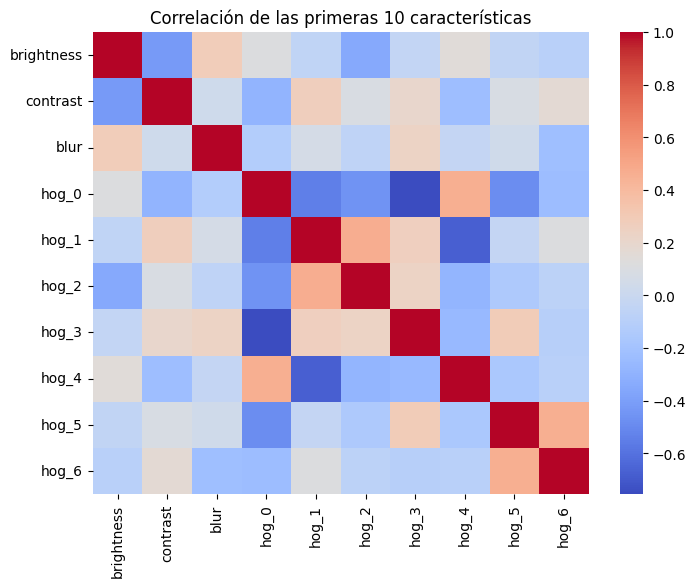

In [27]:
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def extract_features(path):
    img = cv2.imread(path)
    if img is None: return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hog_features = hog(gray, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), feature_vector=True)[:50]
    data = {"brightness": np.mean(gray), "contrast": np.std(gray), "blur": cv2.Laplacian(gray, cv2.CV_64F).var()}
    for i, v in enumerate(hog_features): data[f"hog_{i}"] = v
    return data

print("--- INICIANDO FEATURE ENGINEERING ---")
features = [extract_features(p) for p in tqdm(image_paths[:LIMIT], desc="Features")]
df_features = pd.DataFrame([f for f in features if f])

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)

pca = PCA(n_components=5)
pca.fit(df_scaled)
print(f"Varianza explicada por PCA (5 comp): {pca.explained_variance_ratio_.sum():.2%}")

# Heatmap de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(df_scaled.iloc[:, :10].corr(), cmap="coolwarm")
plt.title("Correlación de las primeras 10 características")
plt.show()

# Setup del Baseline Definitivo (DINO + OCR)

In [28]:
# 1. Configurar Hardware
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 Hardware detectado para IA: {device.upper()}")

# 2. Cargar Modelos (DINO y EasyOCR)
dino_processor = AutoProcessor.from_pretrained("IDEA-Research/grounding-dino-base")
dino_model = AutoModelForZeroShotObjectDetection.from_pretrained("IDEA-Research/grounding-dino-base").to(device)
# Activamos gpu=True para acelerar EasyOCR
reader = easyocr.Reader(['es', 'en'], gpu=True if device == "cuda" else False)

# 3. Funciones Core
def preprocess_crop_for_ocr(crop_img):
    """Upsampling y eliminación de sombras para tickets de matriz de puntos"""
    if crop_img is None or crop_img.size == 0: return None
    # Upsampling
    crop_img = cv2.resize(crop_img, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_CUBIC)
    gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)

    # Erosión (engordar letras)
    kernel_dots = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    gray_thick = cv2.erode(gray, kernel_dots, iterations=1)

    # Eliminar sombras
    kernel_bg = cv2.getStructuringElement(cv2.MORPH_RECT, (45, 45))
    background = cv2.morphologyEx(gray_thick, cv2.MORPH_CLOSE, kernel_bg)
    normalized = cv2.divide(gray_thick, background, scale=255.0)
    normalized = cv2.normalize(normalized, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    # Binarización
    _, thresh = cv2.threshold(normalized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh

def extract_target_pattern_strict(text_list):
    """Regex Estricto: Previene alucinaciones y exige el formato exacto"""
    full_text = " ".join(text_list).upper()
    extracted = []
    # Exige: COL + (1,2,3) + basura opcional + 5 dígitos + espacios + 5 dígitos
    pattern = r"C[O0]L\s*([123])[\.\,\s]*(\d{5})\s+(\d{5})"

    matches = re.findall(pattern, full_text)
    if matches:
        for match in matches:
            standardized = f"COL {match[0]}. {match[1]} {match[2]}"
            extracted.append(standardized)
    return extracted

🚀 Hardware detectado para IA: CPU


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The image processor of type `GroundingDinoImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

# Ejecución Final y Resultados

In [31]:
print("--- INICIANDO EXTRACCIÓN AVANZADA (DINO + OCR) ---")
tickets_processed = {}

for path in tqdm(image_paths[:LIMIT], desc="Procesando tickets"):
    filename = os.path.basename(path)
    img_cv = cv2.imread(path)
    if img_cv is None: continue

    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

    # Inferencia DINO
    inputs = dino_processor(images=img_rgb, text="printed text with numbers.", return_tensors="pt").to(device)
    with torch.no_grad(): outputs = dino_model(**inputs)

    results = dino_processor.post_process_grounded_object_detection(
        outputs, inputs.input_ids, threshold=0.18, text_threshold=0.18, target_sizes=[img_cv.shape[:2]]
    )[0]

    h, w = img_cv.shape[:2]
    target_data_all = []

    # Procesar recortes
    for box in results["boxes"]:
        x1, y1, x2, y2 = map(int, box.tolist())
        pad_x, pad_y = int((x2 - x1) * 0.05), int((y2 - y1) * 0.05)
        x1, y1 = max(0, x1 - pad_x), max(0, y1 - pad_y)
        x2, y2 = min(w, x2 + pad_x), min(h, y2 + pad_y)

        crop = img_cv[y1:y2, x1:x2]
        img_prep = preprocess_crop_for_ocr(crop)

        if img_prep is not None:
            # Allowlist estricto para evitar caracteres basura
            result_text = reader.readtext(img_prep, detail=0, allowlist='COL0123456789., ')
            target_data = extract_target_pattern_strict(result_text)
            if target_data:
                target_data_all.extend(target_data)

    if target_data_all:
        # set() quita duplicados, sorted() los acomoda en COL 1, 2, 3
        tickets_processed[filename] = sorted(list(set(target_data_all)))

# Mostrar resultados
print("\n" + "="*60)
print("📊 RESULTADOS FINALES ORDENADOS")
print("="*60)
print(json.dumps(tickets_processed, indent=4, ensure_ascii=False))
print("="*60)
print(f"✅ Extracción exitosa en {len(tickets_processed)} imágenes.")

--- INICIANDO EXTRACCIÓN AVANZADA (DINO + OCR) ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)



📊 RESULTADOS FINALES ORDENADOS
{
    "1.jpeg": [
        "COL 1. 15355 50899",
        "COL 2. 01146 94344",
        "COL 3. 01816 44947"
    ],
    "10.jpeg": [
        "COL 1. 15869 47453",
        "COL 2. 66601 50814"
    ],
    "100.jpg": [
        "COL 1. 24421 97889",
        "COL 2. 30669 56415",
        "COL 3. 69800 86140"
    ],
    "101.png": [
        "COL 1. 96476 05643",
        "COL 2. 00069 36425",
        "COL 3. 60880 89364"
    ],
    "102.png": [
        "COL 1. 30556 59450",
        "COL 2. 51144 64548",
        "COL 3. 91826 13568"
    ],
    "103.png": [
        "COL 2. 20063 66578",
        "COL 3. 60850 53968"
    ],
    "104.png": [
        "COL 1. 39506 74158",
        "COL 2. 81117 91571",
        "COL 3. 91374 12101"
    ],
    "105.png": [
        "COL 1. 18889 27246",
        "COL 2. 06600 50810",
        "COL 3. 56408 06798"
    ],
    "106.png": [
        "COL 1. 25554 80796",
        "COL 2. 30118 91341",
        "COL 3. 41712 94858"
    ],
    "107.p